# Handgeschriebene Zahlen erkennen

Ein StartUp-Unternehmen hat sich vorgenommen, eine App zu entwickeln, die die Bedienung des Taschenrechners in Ihrem Tablet vereinfachen soll: anstatt die Zahlen und Zeichen mit dem Keyboard einzutippen, soll der Benutzer die Möglichkeit haben, direkt mit dem Touchpad oder Digi-Pencil Rechnungen aufzuschreiben, die die App verstehen und deren Ergebnisse berechnen können soll.

Das Management hat sich darauf geeinigt, in einem ersten Anlauf, sozusagen als *Minimal Viable Product*, nur zu versuchen, die Ziffern $0-9$ von der App erkennen zu lassen und die sonstigen Zeichen ($+, -, \sqrt{}, \cdot, \div $ usw.) zunächst außen vor zu lassen.

In einem Feldversuch wurden die Benutzer der App aufgefordert, mit dem Touchpad die Ziffern $0-9$ aufzumalen und die resultierenden Bilder wurden in einem Datensatz gespeichert. Einige Beispielbilder sehen Sie hier:

<p float="left">
<img src="./assets/example_digit_1.png" width="100" />
<img src="./assets/example_digit_2.png" width="100" />
<img src="./assets/example_digit_3.png" width="100" />
<img src="./assets/example_digit_4.png" width="100" />
<img src="./assets/example_digit_5.png" width="100" />
<img src="./assets/example_digit_6.png" width="100" />
<img src="./assets/example_digit_7.png" width="100" />
</p>

Insgesamt hat der Kunde $10000$ dieser Bilder gesammelt. Für jedes dieser Bilder ist dem Kunden bereits bekannt, welche Zahl darin zu sehen ist, aber diese Information wird Ihnen nicht mitgeteilt. Stattdessen will das Unternehmen anhand dieser $10000$ Bilder testen, ob das Programm, dass Sie entwerfen, tatsächlich funktioniert.

Sie überlegen sich, dass für diese Aufgabe ein *Machine Learning* Modell in Frage kommt. Tatsächlich hat das Unternehmen von den Nutzern noch weitere $20000$ Bilder von handgeschriebenen Ziffern gesammelt. Diese sind von den $10000$ Test-Bildern verschieden. Für diese neuen $20000$ Bilder haben Sie aber Zugriff auf die Information, um welche Ziffer es sich jeweils handelt.


## Fragestellung

## Wie lassen sich die $20000$ Bilder zusammen mit der Information, welche Ziffern sie jeweils darstellen, nutzen, um ein Programm zu schreiben, dass auch die unbekannten $10000$ Test-Bilder richtig erkennt?

## Schreiben Sie ein Programm, dass zu jedem der $10000$ Test-Bilder eine Zahl ausgibt - die Ziffer, die in dem Bild zu erkennen ist.

# Imports

In [15]:
# Imports
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import timeit

import PIL
from PIL import Image
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

# check Pillow version number
# print('Pillow Version:', PIL.__version__)

In [2]:
# Check Operating system
import os
#os.getcwd()

## 1. Daten herunterladen und bereitstellen

Zuallerst müssen Sie die Daten für die folgende Aufgabe finden und herunterladen. Diese befinden sich im Datenaustausch.

Wie Sie die Daten in diesem Jupyter-Notebook verfügbar machen, hängt davon ab, ob Sie das Notebook lokal oder in Google Colab ausführen.

Falls Sie das Notebook lokal ausführen, haben Sie zunächst nichts weiter zu tun. Platzieren Sie die heruntergeladene Datei in einem Ordner Ihrer Wahl und entpacken Sie sie, falls es sich um eine ZIP-Datei handelt.

Falls Sie das Notebook in Google Colab ausführen, müssen Sie die Daten für das Notebook in der Cloud zugänglich machen - das Notebook hat keinen Zugriff auf Ihre lokalen Dateien. Folgen Sie diesem Link für zusätzliche Tipps zum Hochladen von Daten in Google Colab: https://towardsdatascience.com/importing-data-to-google-colab-the-clean-way-5ceef9e9e3c8. 

## Daten sichten und kennenlernen

Zunächst sollten Sie die Daten kennenlernen und verstehen.

Die Daten haben folgende Ordnerstruktur

```
challenge3
│   train_labels.csv 
│
└───test
│   │   10028.png
│   │   10046.png
│   │   ...
│   |   99992.png
│ 
└───train
    │   10000.png
    │   10002.png
    |   ...
    |   99999.png
```

Alle Bilddateien haben die Endung `.png` und haben eine Auflösung von `28px x 28px`. Im Ordner `test` gibt es $10000$ dieser Dateien. Im Ordner `train` sind es $20000$.

Die Datei `train_labels.csv` enthält die Information, welche Ziffer jeweils in den Bildern des Ordners `train` dargestellt ist. Dazu ist in jeder Zeile der Datei zunächst der Dateiname des entsprechenden Bildes (z.B. `97678.png`) und dann die entsprechende Ziffer angegeben.

### Daten laden

In [3]:
import pandas as pd
data_path = "./data/challenge3/"

labels = pd.read_csv(data_path + 'train_labels.csv', header=None)
train_labels = pd.read_csv(data_path + 'train_labels.csv', index_col=0, header=None)
train_labels = train_labels.iloc[:, 0].to_dict()

test_labels = pd.read_csv(data_path + 'test_labels.csv', index_col=0, header=None)
test_labels = test_labels.iloc[:, 0].to_dict()

In [4]:
# Trainingsdaten importieren
images = []
y_train = []

for filename in glob.glob(data_path + "train/*.png"):
    im = Image.open(filename)
    im = im.convert("L")
    im = np.array(im) / 255.
    images.append(im)
    y_train.append(train_labels[os.path.basename(filename)])

y_train = np.array(y_train)
X_train = np.array(images)
# X_train = np.reshape(X_train, (20000*784))
X_train = X_train.reshape(X_train.shape[0], -1)

In [5]:
# Testdaten importieren
test_images = []
y_test = []

for filename in glob.glob(data_path + "test/*.png"):
    im = Image.open(filename)
    im = im.convert("L")
    im = np.array(im) / 255.
    test_images.append(im)
    y_test.append(test_labels[os.path.basename(filename)])

y_test = np.array(y_train)
X_test = np.array(images)
X_test = X_test.reshape(X_test.shape[0], -1)

### Daten sichten

Welche Analysen könnte man auf den Daten ausführen?

Wie könnte man die Daten visualieren?

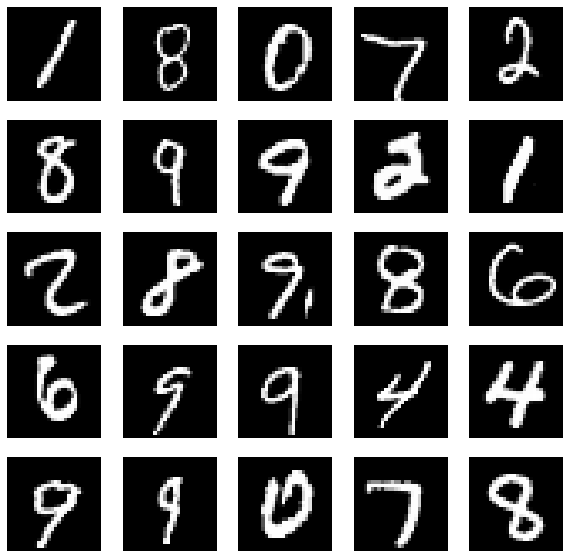

In [6]:
# Visualisierung
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for ax in axes.flatten():
    i = np.random.randint(0, len(X_train))
    image = X_train[i, :]
    image = image.reshape(28, 28)
    ax.imshow(image, cmap="Greys")
    ax.axis("off")

## Das Machine Learning Modell

Wie könnte ein Programm aussehen, dass die Daten in `train_labels.csv` und die Bilder im Ordner `train` nutzt,
um vorherzusagen, welche Ziffern in den Bilder im Ordner `test` zu sehen sind?

### Lineare Regression

In [7]:
model = LogisticRegression(C=0.001, max_iter=1000, solver="lbfgs")
model.fit(X_train, y_train)

LogisticRegression(C=0.001, max_iter=1000)

In [8]:
# die Gewichte haben die gleiche Shape wie die Trainingsbilder
model.coef_.shape

(10, 784)

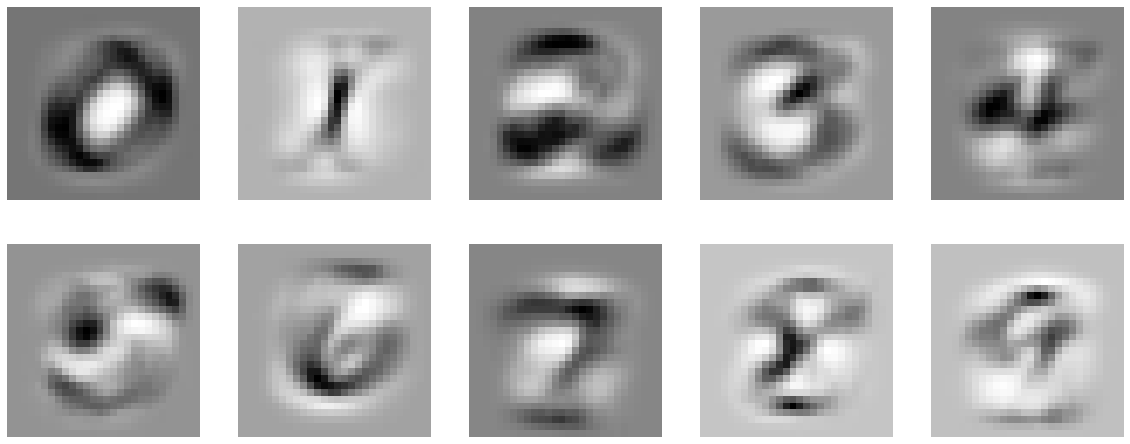

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    coef_image = model.coef_[i, :]
    coef_image = coef_image.reshape(28, 28)
    ax.imshow(coef_image, cmap="Greys_r")
    ax.axis("off")

## Validierung

In [13]:
# Prediction of the test data
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8758

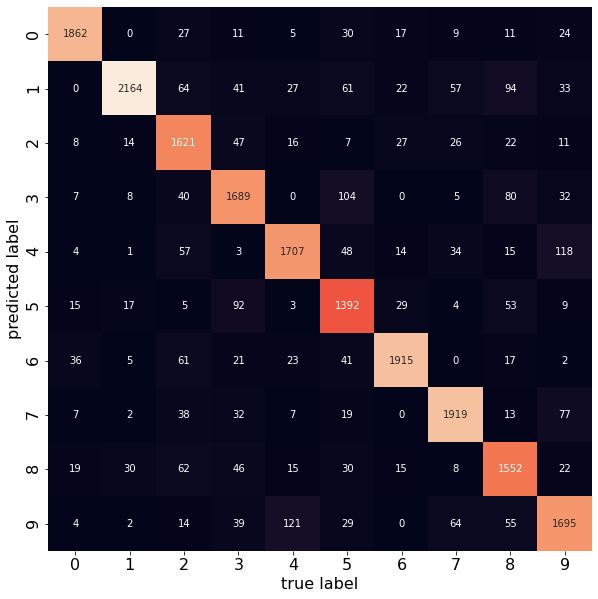

In [16]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False) #, cmap="hot_r")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('true label', fontsize=16)
plt.ylabel('predicted label', fontsize=16);

## Decision Tree

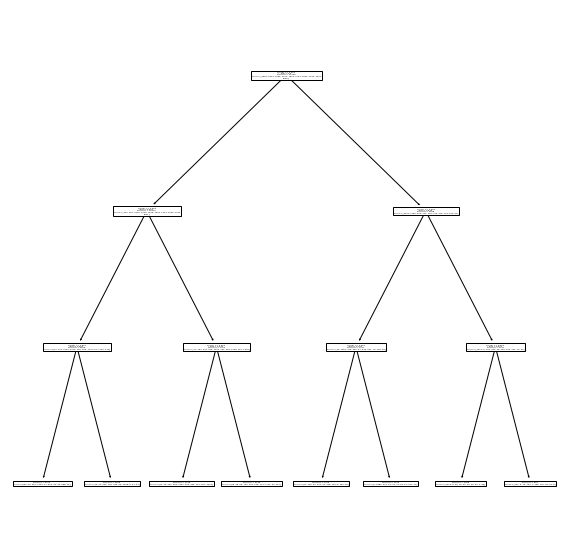

In [17]:
# initiating tree
tree = DecisionTreeClassifier(max_depth=3)

# fitting tree
tree.fit(X_train, y_train)

# Decision Tree plotten
plt.figure(figsize=(10,10))
plot_tree(tree);

In [18]:
""" Tree Evaluation"""
print("Decision Tree mit depth = 3:")
print("")
print("Test score: ", tree.score(X_test, y_test))
print("Train score: ", tree.score(X_train, y_train))

y_pred_tree = tree.predict(X_test)

quadratic_error = np.mean((y_test - y_pred_tree)**2)
absolute_error = np.mean(np.abs(y_test - y_pred_tree))

print("Absolute Error: ", absolute_error)
print("Quadratic Error: ", quadratic_error)
print("Root mean squared error: ", np.sqrt(quadratic_error))

Decision Tree mit depth = 3:

Test score:  0.46555
Train score:  0.46555
Absolute Error:  1.94825
Quadratic Error:  8.80835
Root mean squared error:  2.967886453353632


### Decision Tree Tiefe testen

In [19]:
depths = np.arange(1,20)
train_error = []
test_error = []

for depth in depths:
    tree = DecisionTreeClassifier(max_depth = depth)
    tree.fit(X_train,y_train)
    train_error.append(tree.score(X_train, y_train))
    test_error.append(tree.score(X_test, y_test))

print(f"Bester Testfehler bei Max_depth = {test_error.index(max(test_error))+1}: Trainfehler: {train_error[test_error.index(max(test_error))]}, Testfehler: {max(test_error)}")

Bester Testfehler bei Max_depth = 19: Trainfehler: 0.99505, Testfehler: 0.99505


### Ergebnis testen

In [20]:
# initiating tree
tree_33 = DecisionTreeClassifier(max_depth=33)

# fitting tree
tree_33.fit(X_train, y_train)

""" Tree Evaluation"""
print("Decision Tree mit depth = 33:")
print("")
print("Test score: ", tree_33.score(X_test, y_test))
print("Train score: ", tree_33.score(X_train, y_train))

y_pred_tree_33 = tree_33.predict(X_test)

quadratic_error = np.mean((y_test - y_pred_tree_33)**2)
absolute_error = np.mean(np.abs(y_test - y_pred_tree_33))

print("Absolute Error: ", absolute_error)
print("Quadratic Error: ", quadratic_error)
print("Root mean squared error: ", np.sqrt(quadratic_error))

Decision Tree mit depth = 33:

Test score:  1.0
Train score:  1.0
Absolute Error:  0.0
Quadratic Error:  0.0
Root mean squared error:  0.0


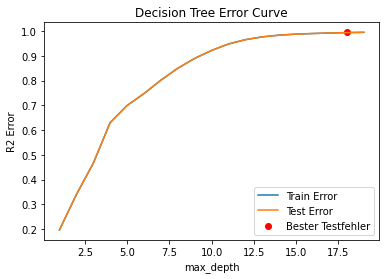

In [21]:
"""Print train and test score"""
#Visualisierung Train-/Testfehler
plt.plot(depths,train_error, label="Train Error")
plt.plot(depths,test_error, label="Test Error")
plt.scatter(test_error.index(max(test_error)),max(test_error), c= "r", label="Bester Testfehler")
plt.ylabel("R2 Error")
plt.xlabel("max_depth")
plt.legend()

plt.title("Decision Tree Error Curve");

In [22]:
""" Print Depth"""
depths = np.arange(1,20)

for depth in depths:
    tree = DecisionTreeClassifier(max_depth = depth)
    tree.fit(X_train,y_train)
    print(f"Tiefe {depth + 1}: ")
    print("Train Score: ", tree.score(X_train, y_train))
    print("Test Score: ", tree.score(X_test, y_test))
    print("")

#print(f"Bester Testfehler bei Max_depth = {test_error.index(max(test_error))+1}: Trainfehler: {train_error[test_error.index(max(test_error))]}, Testfehler: {max(test_error)}")

Tiefe 2: 
Train Score:  0.196
Test Score:  0.196

Tiefe 3: 
Train Score:  0.3389
Test Score:  0.3389

Tiefe 4: 
Train Score:  0.46555
Test Score:  0.46555

Tiefe 5: 
Train Score:  0.63
Test Score:  0.63

Tiefe 6: 
Train Score:  0.6991
Test Score:  0.6991

Tiefe 7: 
Train Score:  0.74745
Test Score:  0.74745

Tiefe 8: 
Train Score:  0.80175
Test Score:  0.80175

Tiefe 9: 
Train Score:  0.84995
Test Score:  0.84995

Tiefe 10: 
Train Score:  0.8898
Test Score:  0.8898

Tiefe 11: 
Train Score:  0.9218
Test Score:  0.9218

Tiefe 12: 
Train Score:  0.94815
Test Score:  0.94815

Tiefe 13: 
Train Score:  0.9655
Test Score:  0.9655

Tiefe 14: 
Train Score:  0.97675
Test Score:  0.97675

Tiefe 15: 
Train Score:  0.98365
Test Score:  0.98365

Tiefe 16: 
Train Score:  0.9878
Test Score:  0.9878

Tiefe 17: 
Train Score:  0.9902
Test Score:  0.9902

Tiefe 18: 
Train Score:  0.9924
Test Score:  0.9924

Tiefe 19: 
Train Score:  0.9939
Test Score:  0.9939

Tiefe 20: 
Train Score:  0.99505
Test Score:  

## Random Forest

In [23]:
X = X_train
y = y_train

In [24]:

tic = timeit.default_timer()

forest = Pipeline(
  [('RandomForest', RandomForestClassifier()),]
)

#X_train, X_test, y_train, y_test= train_test_split(X, y)

forest.fit(X_train, y_train)
toc = timeit.default_timer()
print("Model score: {:} %, calculated in {:.2f} s".format(forest.score(X_test, y_test)*100,
                                                          toc-tic))

Model score: 100.0 %, calculated in 8.56 s


## NN

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

import numpy as np

In [27]:
class SimpleNet(nn.Module):
    def __init__(self, in_features=784):
        # Konstruktor der Super-Klasse (hier nn.Module) aufrufen
        super(SimpleNet, self).__init__()
        
        # Parameter/ Layer/ Architektur speichern
        self.layer1 = nn.Linear(in_features=in_features, out_features=100)
        self.layer2 = nn.Linear(in_features=100, out_features=100)
        self.layer3 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        """ Diese Funktion definiert wie man für jeden Input einen Output generiert"""
        # x is assumed to have shape [N_samples, in_features]  
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return x

In [28]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=32)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=1000)

In [29]:
# Netzwerk instanziieren
net = SimpleNet()

# Verlustfunktion
criterion = nn.CrossEntropyLoss()

# Optimierer
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [30]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, batch in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        #backward
        loss.backward()
        # optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.882
[1,   200] loss: 0.897
[1,   300] loss: 0.641
[1,   400] loss: 0.547
[1,   500] loss: 0.477
[1,   600] loss: 0.493
[2,   100] loss: 0.474
[2,   200] loss: 0.411
[2,   300] loss: 0.418
[2,   400] loss: 0.393
[2,   500] loss: 0.368
[2,   600] loss: 0.387
[3,   100] loss: 0.387
[3,   200] loss: 0.343
[3,   300] loss: 0.360
[3,   400] loss: 0.340
[3,   500] loss: 0.315
[3,   600] loss: 0.344
[4,   100] loss: 0.329
[4,   200] loss: 0.309
[4,   300] loss: 0.327
[4,   400] loss: 0.296
[4,   500] loss: 0.276
[4,   600] loss: 0.305
[5,   100] loss: 0.289
[5,   200] loss: 0.277
[5,   300] loss: 0.296
[5,   400] loss: 0.264
[5,   500] loss: 0.252
[5,   600] loss: 0.278
Finished Training


In [31]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 92 %


In [65]:
class ConvNet(nn.Module):
    def __init__(self, in_features=784):
        # Konstruktor der Super-Klasse (hier nn.Module) aufrufen
        super(ConvNet, self).__init__()
        
        # Parameter/ Layer/ Architektur speichern
        self.conv1 = nn.Conv2d(1, 6, 2) # likely 1 for only grey but 3 for RGB
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2) # (in, out, kernel size)
        self.conv3 = nn.Conv2d(16, 32, 2)
        self.fc1 = nn.Linear(32 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        """ Diese Funktion definiert wie man für jeden Input einen Output generiert"""
        # x is assumed to have shape [N_samples, in_features]  
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [66]:
# Netzwerk instanziieren
net = ConvNet()

# Verlustfunktion
criterion = nn.CrossEntropyLoss()

# Optimierer
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [67]:
"""
x = np.expand_dims(x, 1)      # if numpy array
tensor = tensor.unsqueeze(1)  # if torch tensor

Size without unsqueeze:
got 2-dimensional input of size [32, 784] instead

Size with unsqueeze:
but got 3-dimensional input of size [32, 1, 784] instead

Need:
4-dimensional weight [6, 1, 5, 5]
(n_samples, channels, height, width)
"""
#                (N_samples, channels(Graustufenbild), height, width)
X_train = np.reshape(X_train, (-1, 1, 28, 28))
X_test = np.reshape(X_test, (-1, 1, 28, 28))

X_train_tensor = torch.from_numpy(X_train).float()#.unsqueeze(1)
y_train_tensor = torch.from_numpy(y_train).long()#.unsqueeze(1)

X_test_tensor = torch.from_numpy(X_test).float()#.unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).long()#.unsqueeze(1)

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=32)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=1000)

In [68]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, batch in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # forward
        outputs = net(inputs) 
        # output = model(data[None, ...]) 
        loss = criterion(outputs, labels)
        
        #backward
        loss.backward()
        # optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

RuntimeError: shape '[-1, 2592]' is invalid for input of size 4096

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))